Recurrent neural networks (RNNs) have a long-term dependency issue that LSTM networks solve. LSTMs include feedback connections.[26] With feedback connection property, LSTMs may process whole data sequences without considering each data point individually. Instead, they can process new data points by using the information from earlier data in the sequence to assist their processing. LSTMs are helpful for processing data sequences like text, audio, and general time series.

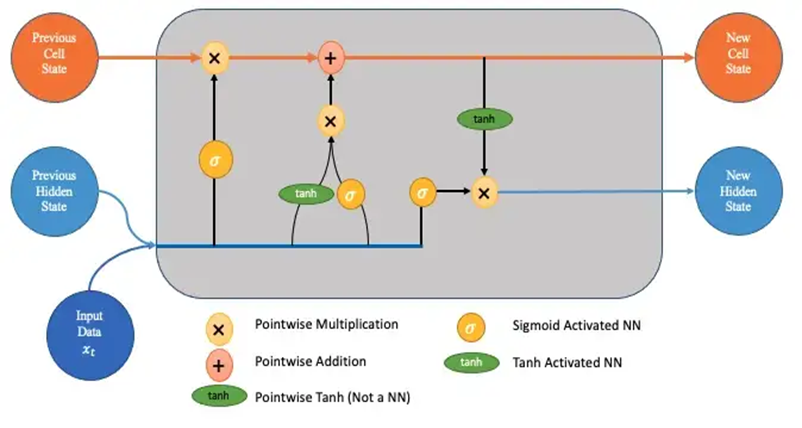

Referances

1. https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
print("TF Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

TF Version:  2.9.2
Keras Version:  2.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6098051978135092642
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7935107678997034874
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
dir_path = "/content/gdrive/MyDrive/Colab Notebooks/Final_Project_Yashkumar_1138765/"

In [ ]:
# Loading dataset
data1=pd.read_excel(dir_path + "Data/Eng_Dataset.xlsx")
data2=pd.read_excel(dir_path + "Data/Guj_Dataset.xlsx")
data3=pd.read_excel(dir_path + "Data/Hin_Dataset.xlsx")
data4=pd.read_excel(dir_path + "Data/Mar_Dataset.xlsx")
data5=pd.read_excel(dir_path + "Data/Pun_Dataset.xlsx")

In [ ]:
# Concatanating the files data
train = pd.concat([
    data1[['comment_text', 'toxic']],
    data2[['comment_text', 'toxic']],
    data3[['comment_text', 'toxic']],
    data4[['comment_text', 'toxic']],
    data5[['comment_text', 'toxic']]
])

In [ ]:
train.head()

,comment_text,toxic
0,Explanation Why the edits made under my userna...,0.0
1,D aww He matches this background colour I m se...,0.0
2,Hey man I m really not trying to edit war It s...,0.0
3,More I can t make any real suggestions on imp...,0.0
4,You sir are my hero Any chance you remember wh...,0.0


In [ ]:
train.tail()

,comment_text,toxic
2994,ਇਸ ਨੂੰ ਇਸ ਦੇ ਕਾਲੇ ਰਿੰਗ ਵਿੱਚ ਹਾਰਡ Fuck OOOOOOOO...,1.0
2995,"ਪ੍ਰਸ਼ਾਸਕ ਕੁਲੀਨਵਾਦੀ ਹਨ, ਮੈਨੂੰ ਕੋਈ ਪਰਵਾਹ ਨਹੀਂ ਹ...",1.0
2996,ਇਸ ਵੇਸਲੇ ਆਊਟਰਿਗਰ ਨੂੰ ਫੱਕ ਕਰੋ ਅਤੇ ਬਾਅਦ ਵਿੱਚ ਜੌਨ...,1.0
2997,ਬ੍ਰਾਂਡਨ ਗੇਅ ਹੈ ਉਹ ਆਪਣੇ ਗਧੇ ਅਤੇ ਮੂੰਹ ਨੂੰ ਡੇਲਡੋਸ...,1.0
2998,"RE ਅਤੇ ਉਸਨੇ ਆਪਣਾ ਨੱਕ ਵੀ ਚੁੱਕਿਆ, ਤੁਸੀਂ ਕਿਸ ਤਰ੍ਹ...",1.0


In [ ]:
train.shape

(14995, 2)

In [ ]:
# Calculate Maximum comment size
train['comment_text'].apply(lambda x:len(str(x).split())).max()

2614

In [ ]:
# Changing column datatypes
train = train.astype({"toxic": int, "comment_text": str})

In [ ]:
train.dtypes

comment_text    object
toxic            int64
dtype: object

In [ ]:
# Shuffle dataset
train = train.sample(frac=1).reset_index(drop=True)

In [ ]:
# split the data in train and test set
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
# Declaring Tokenizer
token = text.Tokenizer(num_words=None, lower=False)
max_len = 1500

In [ ]:
# tokenizing data

token.fit_on_texts(list(xtrain) + list(xvalid))

# Converting texts to sequnces
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

In [ ]:
xtrain_seq[0]

[1239,
 11416,
 5861,
 26510,
 26511,
 20862,
 26512,
 26513,
 11416,
 1,
 926,
 11417,
 6493,
 1,
 28,
 138,
 67,
 8704,
 203,
 818,
 57,
 11418,
 96,
 4100,
 164]

In [ ]:
# Padding the sequences
xtrain_pad = tf.keras.utils.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = tf.keras.utils.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
xtrain_pad[0]

array([   0,    0,    0, ...,   96, 4100,  164], dtype=int32)

In [ ]:
xtrain_pad[0].shape

(1500,)

In [ ]:
# Regulazing Parameter
lamda = 0.01

# Sequential Neural Network 
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                  300,
                  input_length=max_len))
model.add(LSTM(128, kernel_regularizer=regularizers.L2(lamda)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

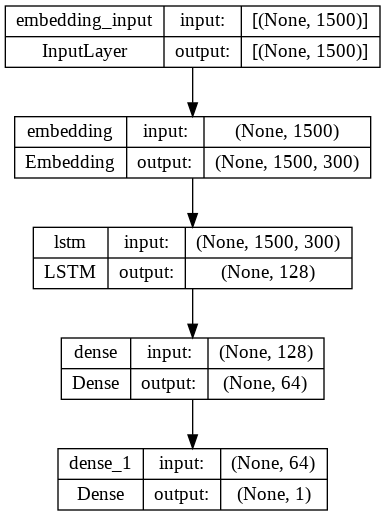

In [ ]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [ ]:
# Callback EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
history=model.fit(xtrain_pad, ytrain,validation_split=0.2, epochs=5, batch_size=128, callbacks=[es])

Epoch 1/5
85/85 [==============================] - 21s 157ms/step - loss: 1.6810 - accuracy: 0.7147 - val_loss: 0.5279 - val_accuracy: 0.8396
Epoch 2/5
85/85 [==============================] - 13s 152ms/step - loss: 0.2647 - accuracy: 0.9250 - val_loss: 0.3899 - val_accuracy: 0.8637
Epoch 3/5
85/85 [==============================] - 13s 152ms/step - loss: 0.0813 - accuracy: 0.9840 - val_loss: 0.4289 - val_accuracy: 0.8540
Epoch 4/5
85/85 [==============================] - 13s 157ms/step - loss: 0.0605 - accuracy: 0.9893 - val_loss: 0.5078 - val_accuracy: 0.8585
Epoch 5/5
85/85 [==============================] - 13s 154ms/step - loss: 0.0244 - accuracy: 0.9979 - val_loss: 0.5913 - val_accuracy: 0.8444
Epoch 5: early stopping


In [ ]:
# Taking values from history callback object
train_values = history.history['loss']
val_values = history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epoch=5

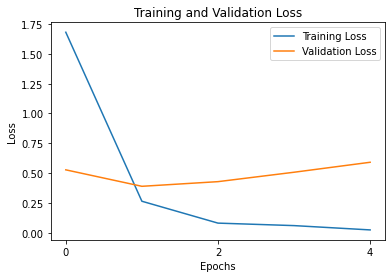

In [ ]:
from matplotlib.pylab import plt
from numpy import arange
 
# integers sequence to represent the epoch numbers
epochs = range(0, epoch)
 
# Plot and label loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# tick locations
plt.xticks(arange(0, epoch, 2))
 
# Display plot
plt.legend(loc='best')
plt.show()

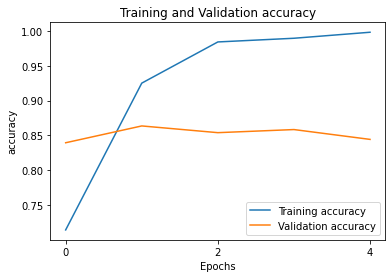

In [ ]:
# integers sequence to represent the epoch numbers
epochs = range(0, epoch)
 
# Plot and label loss values
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
 
# Add title and axes labels
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
 
# tick locations
plt.xticks(arange(0, epoch, 2))
 
# Display plot
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making predications on validation data
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict(xvalid_pad, verbose=0).ravel()]

# Calculating Accuracy Score and Classification report
print("Accuracy: %.2f%%" % (accuracy_score(yvalid, predictions)*100))
print(classification_report(yvalid, predictions))

# Confusion matrix
cf_matrix =confusion_matrix(yvalid, predictions)
pd.DataFrame(cf_matrix)

Accuracy: 85.53%
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       750
           1       0.83      0.89      0.86       750

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



,0,1
0,618,132
1,85,665


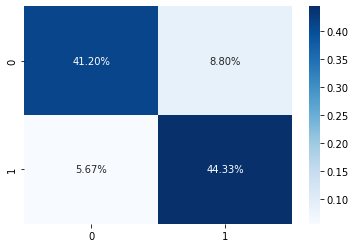

In [ ]:
# Plot Confusion matrix
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
path = dir_path + '/model/my_CNN_model.h5'

In [ ]:
# save model in h5 file
model.save(path, save_format='h5', overwrite=True)

In [ ]:
# load model
l_model = tf.keras.models.load_model(path)
l_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         24357900  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,585,869
Trainable params: 24,585,869
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model on actual data
def evaluate(text):
  token.fit_on_texts(text)
  tokens = token.texts_to_sequences(text)
  seq = []
  for i in tokens:
    for j in i:
      seq.append(j)
  seq = np.array(seq)

  text_pad = tf.keras.utils.pad_sequences([seq,], maxlen=max_len)
  word_index = token.word_index

  result = l_model.predict(text_pad, verbose=0) 
  print("%.5f" % result[0])

  if(result >=0.5):
    print("Toxic")
  else:
    print("Non-Toxic")

In [ ]:
text= " डी aww वह इस पृष्ठभूमि रंग से मेल खाता है मैं प्रतीत होता है कि धन्यवाद टॉक 21 51 जनवरी 11 2016 यूटीसी के साथ फंस गया है"

evaluate(text)

0.16309
Non-Toxic
